<a href="https://colab.research.google.com/github/NehaSontakk/BATH-Prokka-Comparison/blob/main/Coverage_of_query_protein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
annotation_overlaps = pd.read_excel("/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Alignment_Overlaps_Unique_Bedmap_COGs_bin152.xlsx")
annotation_labels = pd.read_excel("/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/bin152_length_comparison.xlsx")

In [3]:
bath_file = pd.read_excel("/content/drive/MyDrive/Lab Work/Parkinsons_Data/BIN152/Deduplication Output/dedup_bin52_test1.xlsx")

In [4]:
bath_file.shape

(508, 23)

In [5]:
annotation_overlaps = annotation_overlaps.loc[:, ~annotation_overlaps.columns.str.contains('^Unnamed')]
annotation_labels = annotation_labels.loc[:, ~annotation_labels.columns.str.contains('^Unnamed')]
bath_file = bath_file.loc[:, ~bath_file.columns.str.contains('^Unnamed')]

In [6]:
merge_columns = ['target name', 'query name', 'E-value']

In [7]:
def extract_info(row):
    if pd.notnull(row['BATH']):
        bath_data = re.split(r'\t|\s+', str(row['BATH']))
        row['BATH_contig'] = bath_data[0]
        if len(bath_data) >= 3:
            row['BATH_annot'] = bath_data[-3]
        else:
            row['BATH_annot'] = None

    if pd.notnull(row['Prokka']):
        prokka_data = re.split(r'\t|\s+', str(row['Prokka']))
        row['Prokka_contig'] = prokka_data[0]
        if len(prokka_data) >= 3:
            row['Prokka_annot'] = prokka_data[3]
        else:
            row['Prokka_annot'] = None
    return row


annotation_overlaps = annotation_overlaps.apply(extract_info, axis=1)

In [8]:
annotation_labels.columns

Index(['BATH', 'BATH_annot', 'BATH_contig', 'BATH_end', 'BATH_start', 'Prokka',
       'Prokka_annot', 'Prokka_contig', 'Prokka_end', 'Prokka_start', 'label',
       'target name', 'query name', 'E-value', 'shifts', 'Prodigal ORF Amino',
       'HMM_Alignment_Length', 'Protein_HMM_filepath',
       'Protein_FA_File_Status', 'Protein_FA_File_Path',
       'Prokka Uniprot Protein Sequence', 'Prodigal ORF Length',
       'Prokka ORF phmmer E-value', 'Prokka ORF phmmer ali from',
       'Prokka ORF phmmer ali to', 'Prokka ORF phmmer length',
       'Prokka ORF HMM phmmer E-value', 'Prokka ORF HMM phmmer ali from',
       'Prokka ORF HMM phmmer ali to', 'Prokka ORF HMM phmmer length',
       'Merged_Column', 'Prokka_SW'],
      dtype='object')

In [9]:
bath_file.columns

Index(['target name', 'accession', 'query name', 'accession1', 'hmm len',
       'hmm from', 'hmm to', 'seq len', 'ali from', 'ali to', 'env from',
       'env to', 'E-value', 'score', 'bias', 'shifts', 'stops', 'pipe',
       'description of target', 'strand', 'ali from flip', 'ali to flip'],
      dtype='object')

In [10]:
annotation_overlaps.columns

Index(['BATH', 'BATH_annot', 'BATH_contig', 'BATH_end', 'BATH_start', 'Prokka',
       'Prokka_annot', 'Prokka_contig', 'Prokka_end', 'Prokka_start', 'label',
       'target name', 'query name', 'E-value', 'shifts', 'Prodigal ORF Amino',
       'HMM_Alignment_Length', 'Protein_HMM_filepath',
       'Protein_FA_File_Status', 'Protein_FA_File_Path',
       'Prokka Uniprot Protein Sequence', 'Prodigal ORF Length',
       'Prokka ORF phmmer E-value', 'Prokka ORF phmmer ali from',
       'Prokka ORF phmmer ali to', 'Prokka ORF phmmer length',
       'Prokka ORF HMM phmmer E-value', 'Prokka ORF HMM phmmer ali from',
       'Prokka ORF HMM phmmer ali to', 'Prokka ORF HMM phmmer length',
       'Merged_Column', 'Prokka_SW', 'Annotation_Match', 'Prokka COGs',
       'BATH COGs', 'Name_or_COG_Match'],
      dtype='object')

Merge dataframes

In [11]:
merge_cols = ['BATH','BATH_contig',
 'Prokka','Prokka_contig','target name', 'query name', 'shifts']

In [12]:
annotation_labels_unique = annotation_labels.drop_duplicates(subset=merge_cols)
annotation_overlaps_unique = annotation_overlaps.drop_duplicates(subset=merge_cols)

# Check the shape to ensure that the rows are unique
print("Unique Annotation Labels Shape:", annotation_labels_unique.shape)
print("Unique Annotation Overlaps Shape:", annotation_overlaps_unique.shape)


Unique Annotation Labels Shape: (384, 32)
Unique Annotation Overlaps Shape: (276, 36)


In [13]:
# Perform an inner join to merge on common columns
merged_annotations = pd.merge(annotation_labels_unique, annotation_overlaps_unique, on=merge_cols, how='left')

# Check the shape of the merged dataframe
print("Merged Annotations Shape after Inner Join:", merged_annotations.shape)


Merged Annotations Shape after Inner Join: (384, 61)


In [14]:
annotation_overlapsmerged_df = pd.merge(bath_file, merged_annotations, on=['target name', 'query name'], how='left')
print("Final DataFrame Shape:", annotation_overlapsmerged_df.shape)

Final DataFrame Shape: (534, 81)


In [15]:
annotation_overlapsmerged_df['hmm coverage'] = (annotation_overlapsmerged_df['hmm to'] - annotation_overlapsmerged_df['hmm from']+1)/annotation_overlapsmerged_df['hmm len'] * 100

In [16]:
annotation_overlapsmerged_df['start nearness'] = (annotation_overlapsmerged_df['hmm from']-1)/annotation_overlapsmerged_df['hmm len'] * 100

In [17]:
plot_overlaps = annotation_overlapsmerged_df.dropna(subset=['hmm coverage'])

In [18]:
x_columns = [col for col in plot_overlaps.columns if col.endswith('_x')]
y_columns = [col.replace('_x', '_y') for col in x_columns]

# Initialize a dictionary to store the columns we want to keep
columns_to_keep = {}

# Compare each pair of columns with `_x` and `_y` suffixes
for x_col, y_col in zip(x_columns, y_columns):
    # Calculate the number of NaNs in each column
    x_nans = plot_overlaps[x_col].isna().sum()
    y_nans = plot_overlaps[y_col].isna().sum()

    # Keep the column with fewer NaNs
    if x_nans <= y_nans:
        columns_to_keep[x_col] = x_col.replace('_x', '')  # Rename to remove `_x`
    else:
        columns_to_keep[y_col] = y_col.replace('_y', '')  # Rename to remove `_y`

# Drop the columns we don't want to keep
plot_overlaps = plot_overlaps.drop(columns=set(x_columns + y_columns) - set(columns_to_keep.keys()))

# Rename the kept columns to remove `_x` or `_y`
plot_overlaps.rename(columns=columns_to_keep, inplace=True)

# Check the cleaned dataframe
print("Final DataFrame Shape after cleaning:", plot_overlaps.shape)
print(plot_overlaps.head())

Final DataFrame Shape after cleaning: (534, 57)
    target name accession query name accession1  hmm len  hmm from  hmm to  \
0  k127_2214054         -     P75788          -      372        17     365   
1  k127_1032572         -     Q35813          -      605        59     477   
2   k127_239001         -     ISBsp7          -      299         8     283   
3   k127_239001         -   MF_01638          -      284        27     263   
4  k127_2214054         -     Q3J4D7          -      709        31     706   

   seq len  ali from  ali to  ...  Prokka ORF HMM phmmer ali to  \
0    32502     13887   14942  ...                           NaN   
1   117210      1077    2300  ...                         525.0   
2   136989     47843   48661  ...                           NaN   
3   136989      3564    4268  ...                         249.0   
4    32502      5636    3611  ...                           NaN   

   Prokka ORF HMM phmmer length  Merged_Column  Prokka_SW  Annotation_Match  \
0

In [19]:
font_size = 16
plt.rc('font', size=font_size)
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('xtick', labelsize=font_size)
plt.rc('ytick', labelsize=font_size)
plt.rc('legend', fontsize=font_size)
plt.rc('figure', titlesize=font_size)

new_order = ['BATH and Prokka Annotated', 'BATH', 'BATH and Prokka Unannotated']
plot_overlaps['label'] = pd.Categorical(plot_overlaps['label'], categories=new_order, ordered=True)
plot_overlaps = plot_overlaps.sort_values('label')

custom_labels = ['BATH and Prokka\nAligned Annotations', 'BATH Annotations\n(not ORFs)', 'BATH Annotations\n(ORFs)']

palette = {
    'BATH and Prokka Annotated': '#7C5F72',
    'BATH': '#E76F51',
    'Prokka Annotated ': '#264653',
    'Prokka Unannotated': '#E9C46A',
    'BATH and Prokka Unannotated': '#F4A261'
}


<ipython-input-20-88e0cdc31a6e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='hmm coverage', data=plot_overlaps, cut=0, inner=None, palette=palette)


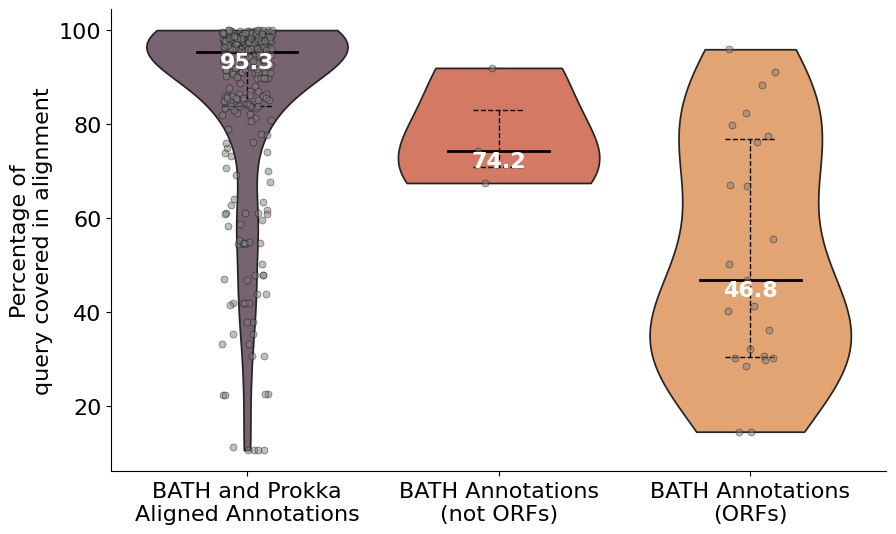

In [20]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='hmm coverage', data=plot_overlaps, cut=0, inner=None, palette=palette)
sns.stripplot(x='label', y='hmm coverage', data=plot_overlaps, edgecolor='black', linewidth=0.5, color='grey', alpha=0.5)
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=0, ha='center')

for idx, label in enumerate(new_order):
    label_data = plot_overlaps[plot_overlaps['label'] == label]['hmm coverage']
    median = label_data.median()
    q1 = label_data.quantile(0.25)
    q3 = label_data.quantile(0.75)

    plt.text(idx, median, f'{median:.1f}', ha='center', va='top', color='white', fontweight='bold')
    plt.plot([idx-0.2, idx+0.2], [median, median], color='black', lw=2)
    plt.plot([idx-0.1, idx+0.1], [q1, q1], color='black', lw=1, linestyle='--')
    plt.plot([idx-0.1, idx+0.1], [q3, q3], color='black', lw=1, linestyle='--')
    plt.plot([idx, idx], [q1, q3], color='black', lw=1, linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.xlabel('')
plt.ylabel('Percentage of\nquery covered in alignment')
plt.savefig("Fig8_querycoverage.svg", dpi=300, transparent=True, bbox_inches='tight')
plt.show()


<ipython-input-21-a111d578bb9b>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='start nearness', cut=0, data=plot_overlaps, inner=None, palette=palette)


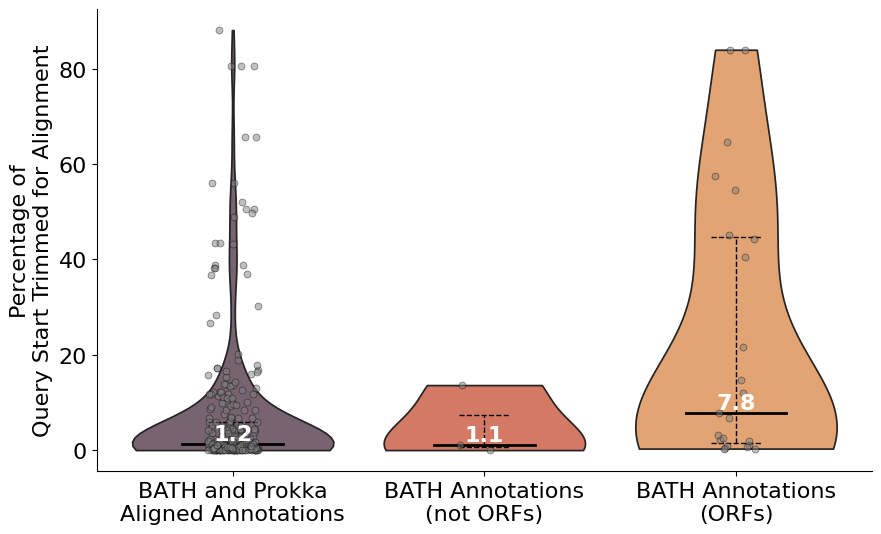

In [21]:
new_order = ['BATH and Prokka Annotated', 'BATH', 'BATH and Prokka Unannotated']
plot_overlaps['label'] = pd.Categorical(plot_overlaps['label'], categories=new_order, ordered=True)
plot_overlaps = plot_overlaps.sort_values('label')
custom_labels = ['BATH and Prokka\nAligned Annotations', 'BATH Annotations\n(not ORFs)', 'BATH Annotations\n(ORFs)']
palette = {
    'BATH and Prokka Annotated': '#7C5F72',
    'BATH': '#E76F51',
    'Prokka Annotated ': '#264653',
    'Prokka Unannotated': '#E9C46A',
    'BATH and Prokka Unannotated': '#F4A261'
}

plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='start nearness', cut=0, data=plot_overlaps, inner=None, palette=palette)
sns.stripplot(x='label', y='start nearness', data=plot_overlaps, edgecolor='black', linewidth=0.5, color='grey', alpha=0.5)
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=0, ha='center')

for idx, label in enumerate(new_order):
    label_data = plot_overlaps[plot_overlaps['label'] == label]['start nearness']
    median = label_data.median()
    q1 = label_data.quantile(0.25)
    q3 = label_data.quantile(0.75)

    plt.text(idx, median, f'{median:.1f}', ha='center', va='bottom', color='white', fontweight='bold')
    plt.plot([idx-0.2, idx+0.2], [median, median], color='black', lw=2)
    plt.plot([idx-0.1, idx+0.1], [q1, q1], color='black', lw=1, linestyle='--')
    plt.plot([idx-0.1, idx+0.1], [q3, q3], color='black', lw=1, linestyle='--')
    plt.plot([idx, idx], [q1, q3], color='black', lw=1, linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.xlabel('')
plt.ylabel('Percentage of\nQuery Start Trimmed for Alignment')

plt.savefig("Fig7_startcutoff.svg", dpi=300, transparent=True, bbox_inches='tight')
plt.show()


<ipython-input-22-b9e3f2050d86>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='shifts', cut=0, data=plot_overlaps, inner=None, palette=palette)


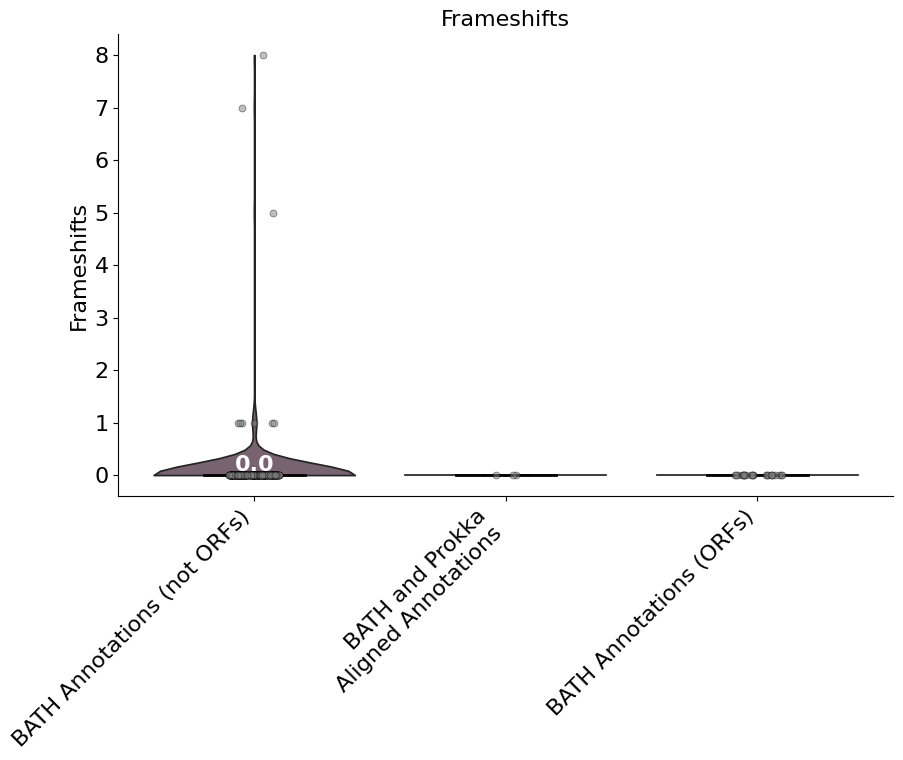

In [22]:
plt.figure(figsize=(10, 6))
palette = {
    'Prokka Unannotated': '#E9C46A',
    'Prokka Annotated ': '#264653',
    'BATH and Prokka Annotated': '#7C5F72',
    'BATH and Prokka Unannotated': '#F4A261',
    'BATH': '#E76F51'
}

sns.violinplot(x='label', y='shifts', cut=0, data=plot_overlaps, inner=None, palette=palette)
sns.stripplot(x='label', y='shifts', data=plot_overlaps, edgecolor='black', linewidth=0.5, color='grey', alpha=0.5)

custom_labels = ['BATH Annotations (not ORFs)', 'BATH and Prokka\nAligned Annotations', 'BATH Annotations (ORFs)']
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=45, ha='right')

for idx, label in enumerate(plot_overlaps['label'].unique()):
    label_data = plot_overlaps[plot_overlaps['label'] == label]['shifts']
    median = label_data.median()
    q1 = label_data.quantile(0.25)
    q3 = label_data.quantile(0.75)

    plt.text(idx, median, f'{median:.1f}', ha='center', va='bottom', color='white', fontweight='bold')
    plt.plot([idx-0.2, idx+0.2], [median, median], color='black', lw=2)
    plt.plot([idx-0.1, idx+0.1], [q1, q1], color='black', lw=1, linestyle='--')
    plt.plot([idx-0.1, idx+0.1], [q3, q3], color='black', lw=1, linestyle='--')
    plt.plot([idx, idx], [q1, q3], color='black', lw=1, linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.title('Frameshifts')
plt.xlabel('')
plt.ylabel('Frameshifts')
plt.show()


## PART 2

In [23]:
plot_overlaps['Name_or_COG_Match'].value_counts()

,count
Name_or_COG_Match,
Yes,187
No,110


In [24]:
plot_overlaps2 = plot_overlaps.dropna(subset=['Name_or_COG_Match'])

In [25]:
plot_overlaps2['Name_or_COG_Match']

,Name_or_COG_Match
0,Yes
23,No
24,No
25,Yes
26,Yes
...,...
311,Yes
325,Yes
321,No
326,No


In [26]:
palette = {
    'Matching annotations\nfor BATH and Prokka': '#448361',
    'Mismatch between\nBATH and Prokka': '#D44C47'
}

<ipython-input-27-4d7ee15315be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_overlaps2['label'] = plot_overlaps2['Name_or_COG_Match'].map(true_name_labels)
<ipython-input-27-4d7ee15315be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='start nearness', cut=0, data=plot_overlaps2, inner=None, palette=palette)


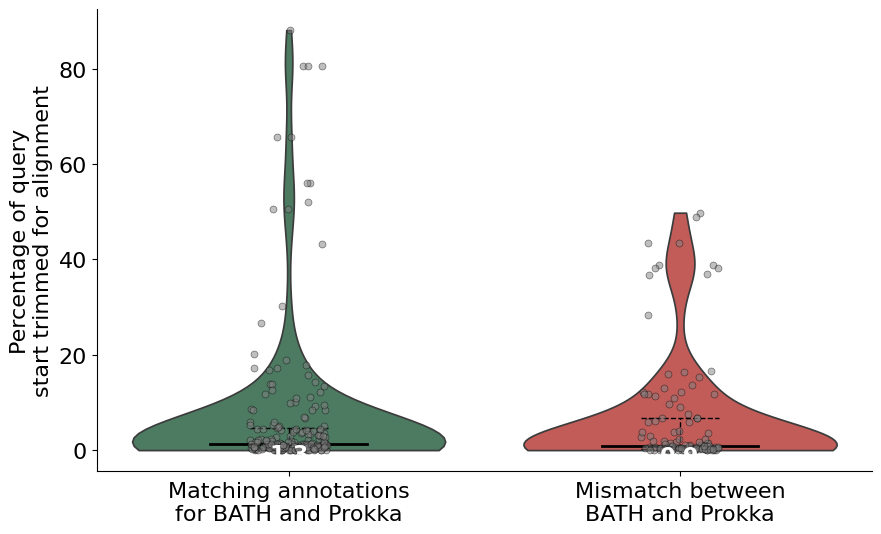

In [27]:
true_name_labels = {'Yes': 'Matching annotations\nfor BATH and Prokka', 'No': 'Mismatch between\nBATH and Prokka'}
plot_overlaps2['label'] = plot_overlaps2['Name_or_COG_Match'].map(true_name_labels)

plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='start nearness', cut=0, data=plot_overlaps2, inner=None, palette=palette)
sns.stripplot(x='label', y='start nearness', data=plot_overlaps2, edgecolor='black', linewidth=0.5, color='grey', alpha=0.5)
plt.xticks(rotation=0, ha='center')
for idx, label in enumerate(plot_overlaps2['label'].unique()):
    label_data = plot_overlaps2[plot_overlaps2['label'] == label]['start nearness']
    median = label_data.median()
    q1 = label_data.quantile(0.25)
    q3 = label_data.quantile(0.75)

    plt.text(idx, median, f'{median:.1f}', ha='center', va='top', color='white', fontweight='bold')
    plt.plot([idx-0.2, idx+0.2], [median, median], color='black', lw=2)
    plt.plot([idx-0.1, idx+0.1], [q1, q1], color='black', lw=1, linestyle='--')
    plt.plot([idx-0.1, idx+0.1], [q3, q3], color='black', lw=1, linestyle='--')
    plt.plot([idx, idx], [q1, q3], color='black', lw=1, linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('')
plt.ylabel('Percentage of query\nstart trimmed for alignment')
plt.savefig("Fig5.svg")
plt.show()

<ipython-input-29-2755e34fdd99>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='hmm coverage', data=plot_overlaps2, cut=0, inner=None, palette=palette)


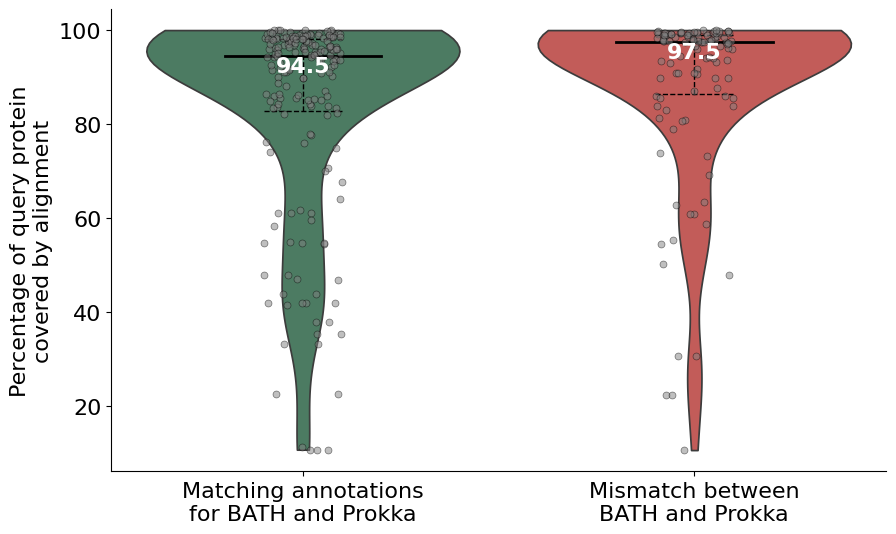

In [29]:
plt.figure(figsize=(10, 6))

# Create a violin plot
sns.violinplot(x='label', y='hmm coverage', data=plot_overlaps2, cut=0, inner=None, palette=palette)

# Add a strip plot on top of the violin plot
sns.stripplot(x='label', y='hmm coverage', data=plot_overlaps2, edgecolor='black', linewidth=0.5, color='grey', alpha=0.5)

# Customize the x-axis labels
plt.xticks(rotation=0, ha='center')

# Calculate and annotate the median and quartile values
for idx, label in enumerate(plot_overlaps2['label'].unique()):
    label_data = plot_overlaps2[plot_overlaps2['label'] == label]['hmm coverage']
    median = label_data.median()
    q1 = label_data.quantile(0.25)
    q3 = label_data.quantile(0.75)

    plt.text(idx, median, f'{median:.1f}', ha='center', va='top', color='white', fontweight='bold')
    plt.plot([idx-0.2, idx+0.2], [median, median], color='black', lw=2)
    plt.plot([idx-0.1, idx+0.1], [q1, q1], color='black', lw=1, linestyle='--')
    plt.plot([idx-0.1, idx+0.1], [q3, q3], color='black', lw=1, linestyle='--')
    plt.plot([idx, idx], [q1, q3], color='black', lw=1, linestyle='--')

# Customize the plot appearance
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# Add title and labels
#plt.title('Percentage of Query HMM covered in BATH and Prokka aligned annotations')
plt.xlabel('')
plt.ylabel('Percentage of query protein\ncovered by alignment')
plt.savefig("Fig5C_query_coverage.svg", dpi=300, transparent=True, bbox_inches='tight')
plt.show()


<ipython-input-30-f1206dc1439e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='shifts', data=plot_overlaps2, cut=0, inner=None, palette=palette)


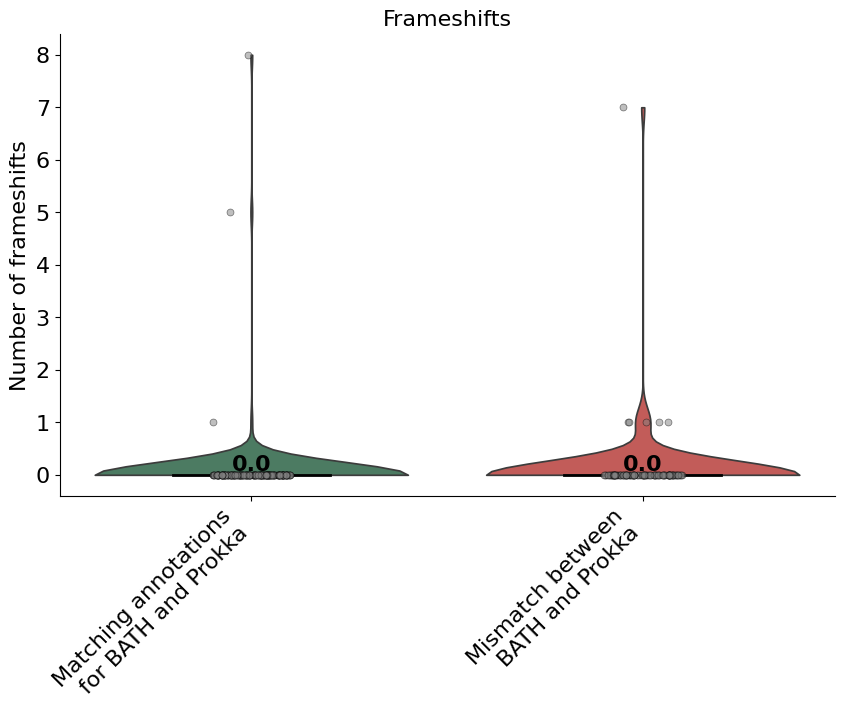

In [30]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='shifts', data=plot_overlaps2, cut=0, inner=None, palette=palette)

sns.stripplot(x='label', y='shifts', data=plot_overlaps2, edgecolor='black', linewidth=0.5, color='grey', alpha=0.5)

plt.xticks(rotation=45, ha='right')

for idx, label in enumerate(plot_overlaps2['label'].unique()):
    label_data = plot_overlaps2[plot_overlaps2['label'] == label]['shifts']
    median = label_data.median()
    q1 = label_data.quantile(0.25)
    q3 = label_data.quantile(0.75)

    plt.text(idx, median, f'{median:.1f}', ha='center', va='bottom', color='black', fontweight='bold')
    plt.plot([idx-0.2, idx+0.2], [median, median], color='black', lw=2)
    plt.plot([idx-0.1, idx+0.1], [q1, q1], color='black', lw=1, linestyle='--')
    plt.plot([idx-0.1, idx+0.1], [q3, q3], color='black', lw=1, linestyle='--')
    plt.plot([idx, idx], [q1, q3], color='black', lw=1, linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('Frameshifts')
plt.xlabel('')
plt.ylabel('Number of frameshifts')
plt.show()